# SOM Exploration with Provenance (Assignment 3)
New notebook for the ARFF dataset (Phase classes D/H/P/R/S), keeping provenance logging.

In [11]:
# Imports
import os, json, datetime, uuid, typing
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from PySOMVis.minisom import MiniSom
from starvers.starvers import TripleStoreEngine

In [12]:
executed_by = 'stud-id_12434740'
group_id = '02'
student_a = 'stud-id_12434740'
student_b = 'stud-id_12404765'
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

In [13]:
# Starvers endpoints and engine
get_endpoint = 'https://starvers.ec.tuwien.ac.at/BI2025'
post_endpoint = 'https://starvers.ec.tuwien.ac.at/BI2025/statements'
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)
base_iri_local = f'https://starvers.ec.tuwien.ac.at/SOS2025/{group_id}/'
prefixes = {
    'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'iao': 'http://purl.obolibrary.org/obo/',
    'vivo': 'http://vivoweb.org/ontology/core#',
    '': base_iri_local,
}
def now():
    t = datetime.datetime.now(datetime.timezone.utc)
    return t.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'

In [14]:
# Register persons and roles (reuse from previous notebook if already inserted)
subj_a = f'<{base_iri_local}{student_a}>'
id_a   = f'<{base_iri_local}{student_a}_id>'
subj_b = f'<{base_iri_local}{student_b}>'
id_b   = f'<{base_iri_local}{student_b}_id>'
role_triples = [
    f'<{base_iri_local}{code_writer_role}> rdf:type prov:Role .',
    f'<{base_iri_local}{code_executor_role}> rdf:type prov:Role .',
]
reg_triples = [
    f'{subj_a} rdf:type foaf:Person .',
    f'{subj_a} rdf:type prov:Agent .',
    f'{subj_a} foaf:givenName "Jonas" .',
    f'{subj_a} foaf:familyName "Kruse" .',
    f'{id_a} rdf:type iao:IAO_0000578 .',
    f'{id_a} rdfs:label "Immatriculation number" .',
    f'{id_a} iao:IAO_0000219 "12434740"^^xsd:string .',
    f'{subj_a} vivo:identifier {id_a} .',
    f'{subj_b} rdf:type foaf:Person .',
    f'{subj_b} rdf:type prov:Agent .',
    f'{subj_b} foaf:givenName "Paul" .',
    f'{subj_b} foaf:familyName "Himstedt" .',
    f'{id_b} rdf:type iao:IAO_0000578 .',
    f'{id_b} rdfs:label "Immatriculation number" .',
    f'{id_b} iao:IAO_0000219 "12404765"^^xsd:string .',
    f'{subj_b} vivo:identifier {id_b} .',
]
engine.insert(role_triples, prefixes=prefixes)
engine.insert(reg_triples, prefixes=prefixes)

## Data Loading and Description

In [15]:
# Load ARFF dataset (Phase labels D/H/P/R/S)
data_raw, meta = arff.loadarff('dataset.arff')
df = pd.DataFrame(data_raw)
df['Phase'] = df['Phase'].astype(str).str.strip("b'")
df['Phase'] = df['Phase'].str.replace("'", '', regex=False)
df['Phase'] = df['Phase'].astype('category')
feature_cols = [c for c in df.columns if c != 'Phase']
X = df[feature_cols].apply(pd.to_numeric)
y = df['Phase']
display(df.head())
print('Shape:', df.shape)
print('Class counts:\n', y.value_counts())

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,X27,X28,X29,X30,X31,X32,Phase
0,-0.005009,-0.000964,0.000573,0.008623,0.005667,0.001302,-0.000631,0.000130,-0.000048,0.007762,...,1.880800e-04,0.005133,0.010400,0.000646,0.007871,0.004631,0.000963,0.000092,0.000438,D
1,0.004905,0.001209,-0.000649,0.004737,0.003166,0.000819,-0.000572,-0.000015,0.000023,0.002706,...,-7.500000e-07,0.005093,0.005756,0.000573,0.003459,0.000730,0.000332,0.000012,0.000433,D
2,-0.002393,-0.000216,0.000136,0.003028,0.001212,0.000336,-0.000449,0.000017,0.000047,0.002868,...,-3.920000e-05,0.002406,0.003279,0.000452,0.003261,0.002412,0.000852,0.000042,0.000202,D
3,-0.001394,-0.000242,0.000056,0.001182,0.000575,0.000225,-0.000479,-0.000050,0.000104,0.001171,...,-3.184000e-05,0.001416,0.001334,0.000493,0.001358,0.000313,0.000611,0.000029,0.000596,D
4,-0.000156,-0.000004,0.000023,0.001585,0.000630,0.000094,-0.000303,0.000097,0.000065,0.001579,...,-2.015000e-05,0.000158,0.001709,0.000325,0.001713,0.000203,0.000069,0.000038,0.000069,D


Shape: (9873, 33)
Class counts:
 Phase
S    2950
D    2741
P    2097
R    1087
H     998
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
X1,9873.0,0.000016,0.007183,-0.072620,-0.001743,0.000010,0.001675,0.073446
X2,9873.0,0.000020,0.009816,-0.079209,-0.001685,0.000029,0.001980,0.071600
X3,9873.0,0.000013,0.007082,-0.084849,-0.000415,-0.000004,0.000367,0.091322
X4,9873.0,-0.000002,0.008988,-0.095705,-0.002148,-0.000009,0.002485,0.071854
X5,9873.0,-0.000006,0.012803,-0.107258,-0.002852,-0.000029,0.002885,0.132058


Series([], dtype: int64)

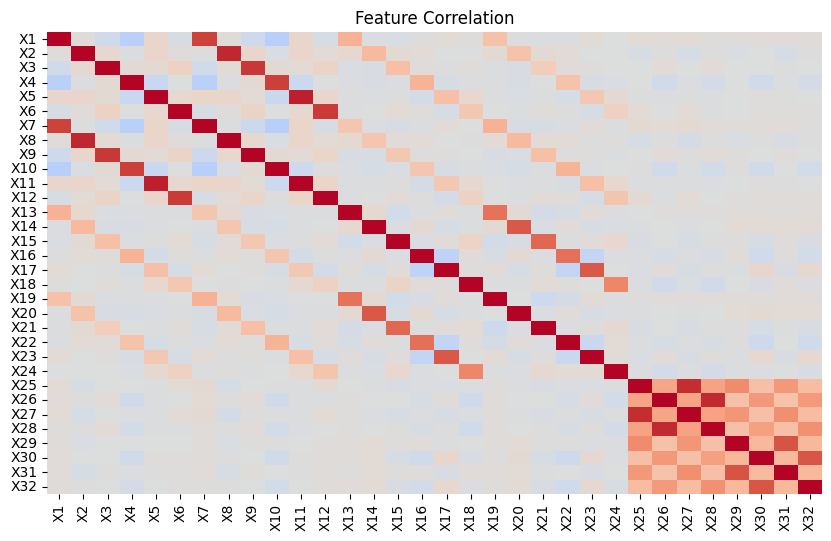

In [16]:
# Basic stats and correlations
desc = X.describe().T
missing = df.isna().sum()
corr = X.corr(method='pearson')
display(desc.head())
display(missing[missing>0])
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0, cbar=False)
plt.title('Feature Correlation')
plt.show()

## Preprocessing

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled shape:', X_scaled.shape)

Scaled shape: (9873, 32)


## SOM Utilities

In [20]:
def topographic_error(som: MiniSom, data: np.ndarray) -> float:
    # Use built-in method of MiniSom (compatible with bundled PySOMVis).
    return som.topographic_error(data)

def u_matrix(som: MiniSom, scaling='sum') -> np.ndarray:
    return som.distance_map(scaling=scaling)

def train_som(config: dict, data: np.ndarray):
    m, n = config['m'], config['n']
    sigma = config['sigma']
    lr = config['learning_rate']
    iters = config['iterations']
    seed = config.get('seed', 0)
    # MiniSom expects x,y instead of m,n
    som = MiniSom(x=m, y=n, input_len=data.shape[1], sigma=sigma, learning_rate=lr, random_seed=seed)
    som.random_weights_init(data)
    som.train_random(data, num_iteration=iters, verbose=False)
    q_error = som.quantization_error(data)
    t_error = topographic_error(som, data)
    return som, q_error, t_error

def log_run_prov(run_id: str, config: dict, q_error: float, t_error: float):
    assoc_id = f'assoc_{uuid.uuid4().hex}'
    # Escape backslashes and quotes so the JSON fits into a Turtle literal.
    cfg_literal = json.dumps(config).replace('\\', '\\\\').replace('"', '\\"')
    triples = [
        f':{run_id} rdf:type prov:Activity .',
        f':{run_id} rdfs:label "{config.get('desc','SOM run')}" .',
        f':{run_id} prov:qualifiedAssociation :{assoc_id} .',
        f':{assoc_id} rdf:type prov:Association .',
        f':{assoc_id} prov:agent :{executed_by} .',
        f':{assoc_id} prov:hadRole :{code_executor_role} .',
        f':{run_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
        f':{run_id} prov:endedAtTime "{now()}"^^xsd:dateTime .',
        f':{run_id}_config rdf:type prov:Entity .',
        f':{run_id}_config rdfs:comment "{cfg_literal}" .',
        f':{run_id}_config prov:wasGeneratedBy :{run_id} .',
        f':{run_id}_qe rdf:type prov:Entity .',
        f':{run_id}_qe rdfs:comment "quantization_error={q_error:.6f}" .',
        f':{run_id}_qe prov:wasGeneratedBy :{run_id} .',
        f':{run_id}_te rdf:type prov:Entity .',
        f':{run_id}_te rdfs:comment "topographic_error={t_error:.6f}" .',
        f':{run_id}_te prov:wasGeneratedBy :{run_id} .',
    ]
    engine.insert(triples, prefixes=prefixes)

## Experiment Grid (Tasks 1-7)

In [ ]:
n = X_scaled.shape[0]
grid_reg = int(np.ceil(np.sqrt(n) / 2))
safe_sigma = grid_reg / 2
configs = [
    # Task 1: Regular SOM (Fixed Sigma and Iterations)
    # INCREASED ITERATIONS to ensure convergence (approx 5 epochs)
    {'run_id':'som_regular', 'desc':'Regular SOM', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':0.5, 'iterations':10000, 'seed':1},

    # Task 2: Different Seed
    {'run_id':'som_seed_alt', 'desc':'Regular SOM different seed', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':0.5, 'iterations':10000, 'seed':7},

    # Task 3: Map Sizes
    # Small map (sigma adjusted down slightly)
    {'run_id':'som_small', 'desc':'Small map', 'm':max(4, grid_reg//2), 'n':max(4, grid_reg//2), 
     'sigma':safe_sigma/2, 'learning_rate':0.5, 'iterations':10000, 'seed':1},
    # Large map (sigma adjusted up)
    {'run_id':'som_large', 'desc':'Large map', 'm':grid_reg*2, 'n':grid_reg*2, 
     'sigma':safe_sigma*2, 'learning_rate':0.5, 'iterations':10000, 'seed':1},

    # Task 4: Too Small Radius
    # Keep sigma tiny (0.5) to ensure it fails as requested
    {'run_id':'som_large_too_small_sigma', 'desc':'Large map too-small radius', 'm':grid_reg*2, 'n':grid_reg*2, 
     'sigma':0.5, 'learning_rate':0.5, 'iterations':10000, 'seed':1},

    # Task 5: Learning Rates
    {'run_id':'som_lr_too_high', 'desc':'Regular map high LR', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':2.5, 'iterations':10000, 'seed':1}, # 2.5 ensures instability
    {'run_id':'som_lr_too_low', 'desc':'Regular map low LR', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':0.01, 'iterations':10000, 'seed':1},
]
iters_sweep = [2,5,10,50,100,1000,5000,10000]
for k in iters_sweep:
    configs.append({'run_id':f'som_iter_{k}', 'desc':f'Iteration sweep {k}', 'm':grid_reg, 'n':grid_reg, 'sigma':safe_sigma, 'learning_rate':0.5, 'iterations':k, 'seed':1})
results = []
for cfg in configs:
    print('Training', cfg['run_id'])
    som, qe, te = train_som(cfg, X_scaled)
    results.append({'run_id':cfg['run_id'], 'desc':cfg['desc'], 'qe':qe, 'te':te, 'm':cfg['m'], 'n':cfg['n'], 'sigma':cfg['sigma'], 'lr':cfg['learning_rate'], 'iterations':cfg['iterations'], 'seed':cfg['seed']})
    log_run_prov(cfg['run_id'], cfg, qe, te)
results_df = pd.DataFrame(results)
display(results_df.sort_values('qe').head())

Training som_regular
Training som_seed_alt
Training som_small
Training som_large
Training som_large_too_small_sigma


c:\Users\kronask\OneDrive - TU Wien\TU Wien\3. Semester\Self-Organising-Systems\3. Assignment\.venv\Lib\site-packages\PySOMVis\minisom.py:535: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Training som_lr_too_high
Training som_lr_too_low
Training som_iter_2
Training som_iter_5
Training som_iter_10
Training som_iter_50
Training som_iter_100
Training som_iter_1000
Training som_iter_5000
Training som_iter_10000


,run_id,desc,qe,te,m,n,sigma,lr,iterations,seed
4,som_large_too_small_sigma,Large map too-small radius,0.708982,0.998987,100,100,0.5,0.5,1500,1
7,som_iter_2,Iteration sweep 2,1.730099,0.994328,50,50,2.5,0.5,2,1
8,som_iter_5,Iteration sweep 5,1.734329,0.993923,50,50,2.5,0.5,5,1
9,som_iter_10,Iteration sweep 10,1.738553,0.994024,50,50,2.5,0.5,10,1
10,som_iter_50,Iteration sweep 50,1.789310,0.990479,50,50,2.5,0.5,50,1


## Visualization Helpers

In [22]:
def plot_umatrix(som: MiniSom, title='U-Matrix'):
    um = u_matrix(som)
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(um, cmap='bone')
    plt.colorbar()
    plt.show()

def plot_hits(som: MiniSom, data: np.ndarray, labels: pd.Series, title='Hit histogram'):
    hits = np.zeros((som._weights.shape[0], som._weights.shape[1]))
    for x in data:
        i,j = som.winner(x)
        hits[i,j] += 1
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(hits, cmap='viridis')
    plt.colorbar()
    plt.show()

## Example: Visualize the regular SOM

som_regular: QE=2.5081, TE=0.5243


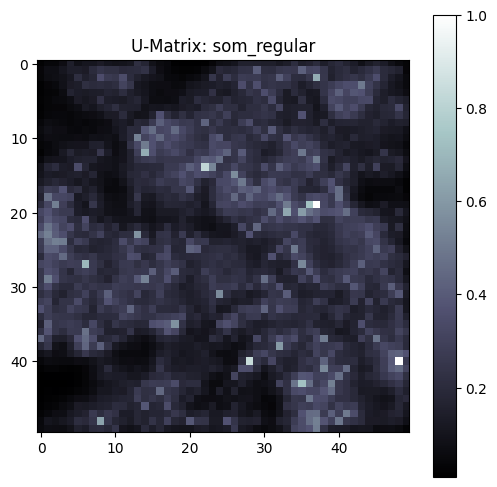

som_seed_alt: QE=2.4844, TE=0.5364


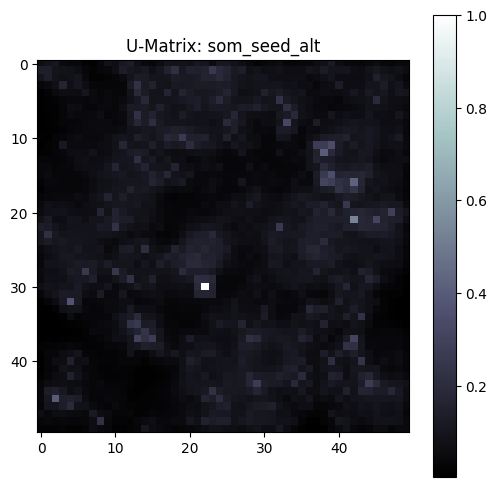

som_small: QE=2.7729, TE=0.2341


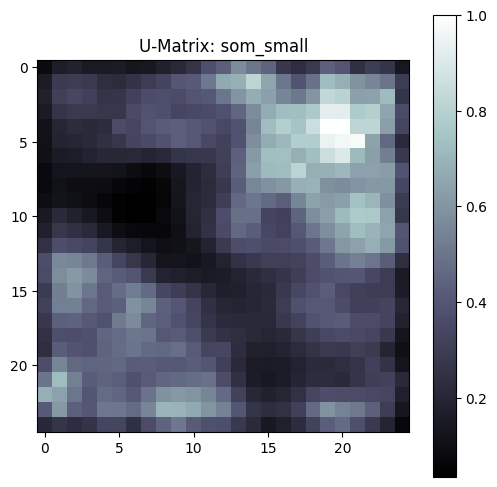

som_large: QE=2.1756, TE=0.6116


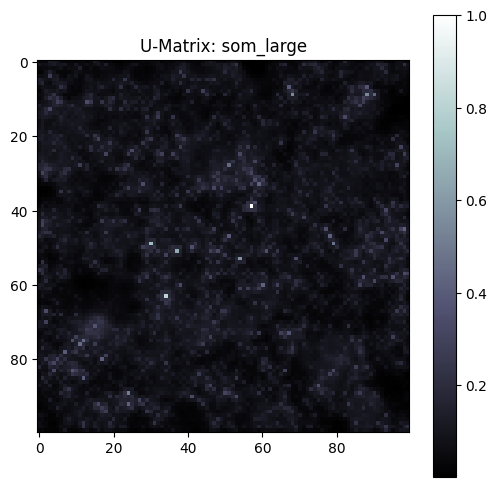

c:\Users\kronask\OneDrive - TU Wien\TU Wien\3. Semester\Self-Organising-Systems\3. Assignment\.venv\Lib\site-packages\PySOMVis\minisom.py:535: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


som_large_too_small_sigma: QE=0.7090, TE=0.9990


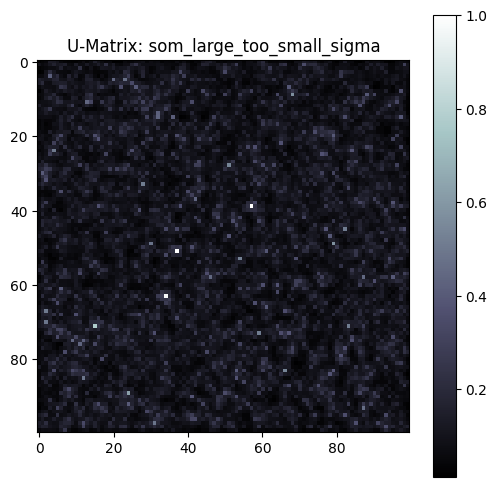

som_lr_too_high: QE=2.5697, TE=0.2701


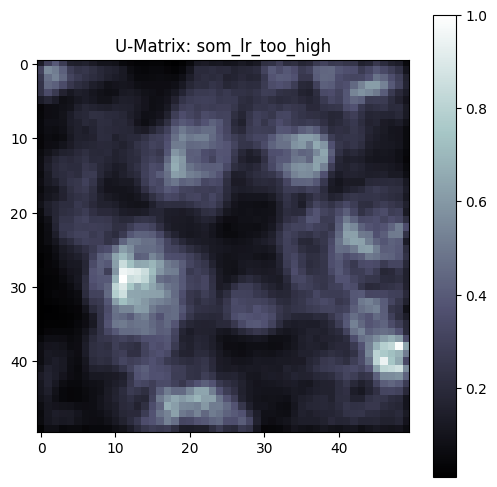

som_lr_too_low: QE=1.8757, TE=0.9869


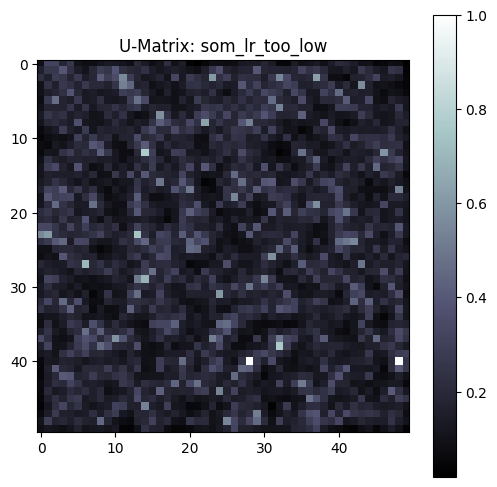

som_iter_2: QE=1.7301, TE=0.9943


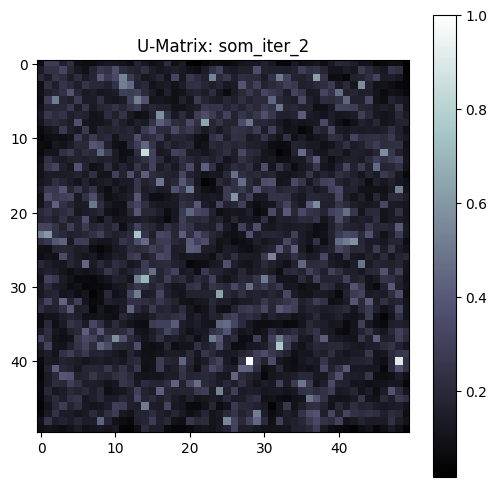

som_iter_5: QE=1.7343, TE=0.9939


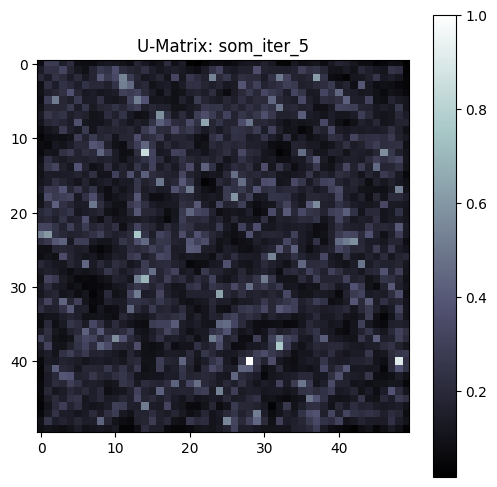

som_iter_10: QE=1.7386, TE=0.9940


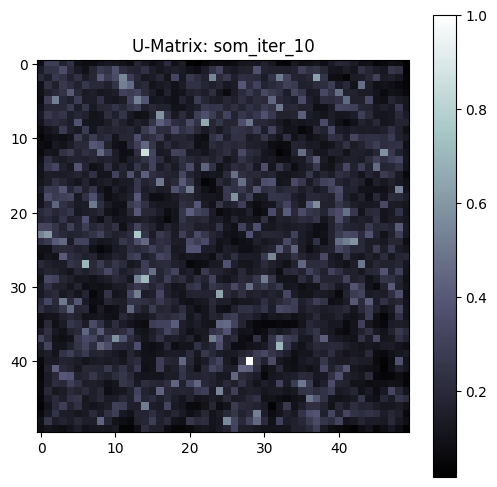

som_iter_50: QE=1.7893, TE=0.9905


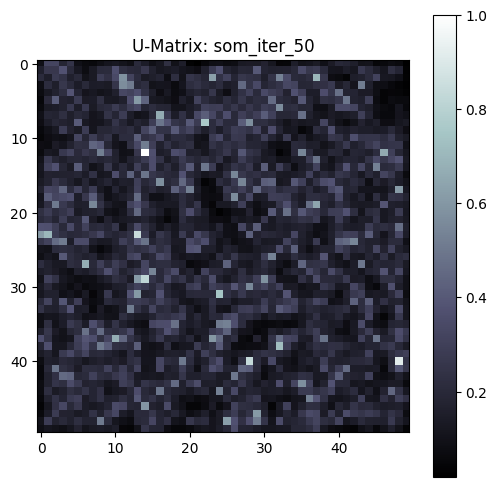

som_iter_100: QE=1.8658, TE=0.9887


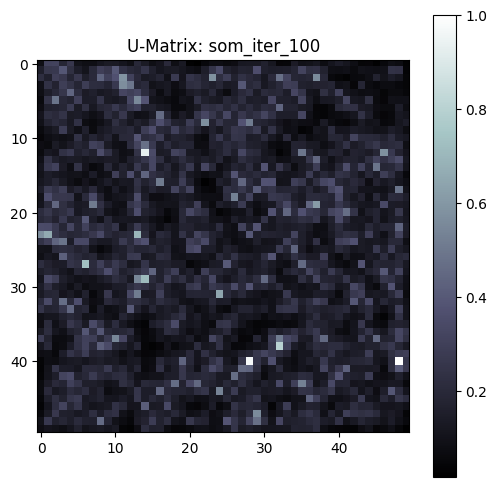

som_iter_1000: QE=2.5081, TE=0.5243


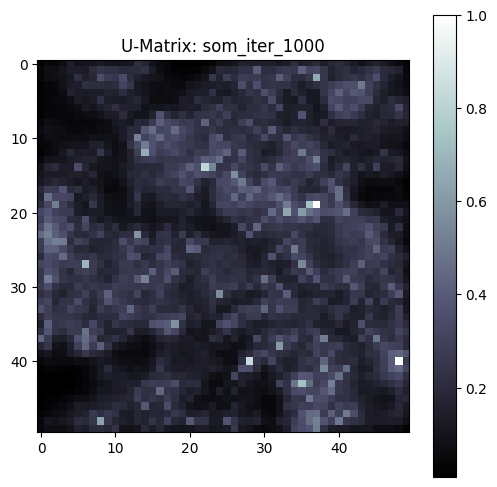

som_iter_5000: QE=2.4475, TE=0.1471


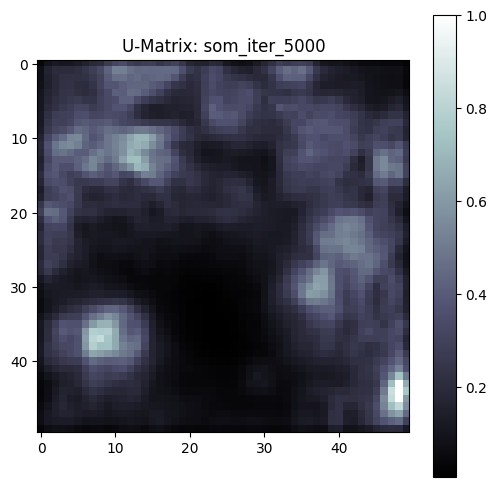

som_iter_10000: QE=2.0652, TE=0.1110


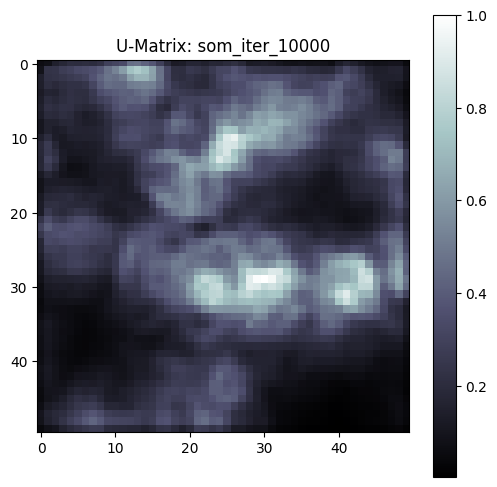

In [24]:
# Plot U-Matrices for all configured SOMs
for cfg in configs:
    som, qe, te = train_som(cfg, X_scaled)
    print(f"{cfg['run_id']}: QE={qe:.4f}, TE={te:.4f}")
    plot_umatrix(som, title=f"U-Matrix: {cfg['run_id']}")